## IB - Sales Outlier Detection (Low-Pass Filter)

By: Renaud Justin Beaupre

In this notebook, I will be applying the principles behind [Pramit Choudhary's article on anomaly detection](https://www.datascience.com/blog/python-anomaly-detection) onto IB's sales data from March 2017-2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
data = pd.read_csv('sales_2017_2019.csv')
data.head()

,day,orders,gross_sales,discounts,returns,net_sales,shipping,taxes,total_sales
0,2017-03-01,341,12721.0,-398.20,-46.50,12276.30,1349.96,18.59,13644.85
1,2017-03-02,324,11998.0,-359.70,-225.55,11412.75,1018.58,21.15,12452.48
2,2017-03-03,304,11612.0,-392.00,-78.00,11142.00,949.34,37.76,12129.10
3,2017-03-04,298,10485.0,-309.25,0.00,10175.75,975.00,25.64,11176.39
4,2017-03-05,343,13220.0,-344.25,-237.00,12638.75,1375.79,23.68,14038.22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 9 columns):
day            761 non-null object
orders         761 non-null int64
gross_sales    761 non-null float64
discounts      761 non-null float64
returns        761 non-null float64
net_sales      761 non-null float64
shipping       761 non-null float64
taxes          761 non-null float64
total_sales    761 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 53.6+ KB


In [4]:
data.describe()

,orders,gross_sales,discounts,returns,net_sales,shipping,taxes,total_sales
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,699.975033,24453.899106,-2703.575480,-554.610999,21195.712628,2622.170105,538.671892,24356.554625
std,454.354129,16715.811342,5293.159431,613.733509,11709.265702,1651.187180,593.702453,13788.007180
min,128.000000,4862.000000,-72154.630000,-4412.390000,4680.500000,524.000000,11.410000,5271.310000
25%,370.000000,13824.000000,-2322.700000,-857.850000,13043.800000,1445.040000,115.420000,14678.010000
50%,665.000000,22447.400000,-1282.250000,-333.450000,20345.980000,2446.000000,205.290000,23386.280000
75%,858.000000,29132.200000,-526.500000,-82.400000,25982.910000,3241.090000,896.550000,30070.310000
max,5058.000000,207707.300000,-113.950000,0.000000,142878.030000,18600.000000,5244.500000,166475.470000


In [5]:
data = data.drop(columns=['orders','gross_sales','discounts','returns','net_sales','shipping','taxes'])
data.head() #Drop the columns we don't need

,day,total_sales
0,2017-03-01,13644.85
1,2017-03-02,12452.48
2,2017-03-03,12129.10
3,2017-03-04,11176.39
4,2017-03-05,14038.22


In [6]:
data.insert(0, 'days', range(0, 0 + len(data)))
data.drop(columns=['day'], inplace=True)
data.head() #Instead of a timestamp, we're just going to use an incremeneter

,days,total_sales
0,0,13644.85
1,1,12452.48
2,2,12129.10
3,3,11176.39
4,4,14038.22


In [7]:
data_array = data.values
data_array #And pass the data as an array

array([[0.000000e+00, 1.364485e+04],
       [1.000000e+00, 1.245248e+04],
       [2.000000e+00, 1.212910e+04],
       ...,
       [7.580000e+02, 4.067642e+04],
       [7.590000e+02, 3.820268e+04],
       [7.600000e+02, 3.548094e+04]])

In [8]:
from __future__ import division
from itertools import count
from numpy import linspace, loadtxt, ones, convolve
import collections

def moving_average(data_array, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data_array, window, 'same')

In [9]:
def explain_anomalies(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    #Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [10]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    #Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [14]:
def plot_results(x, y, window_size, sigma_value=1, text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    #Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    #Add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

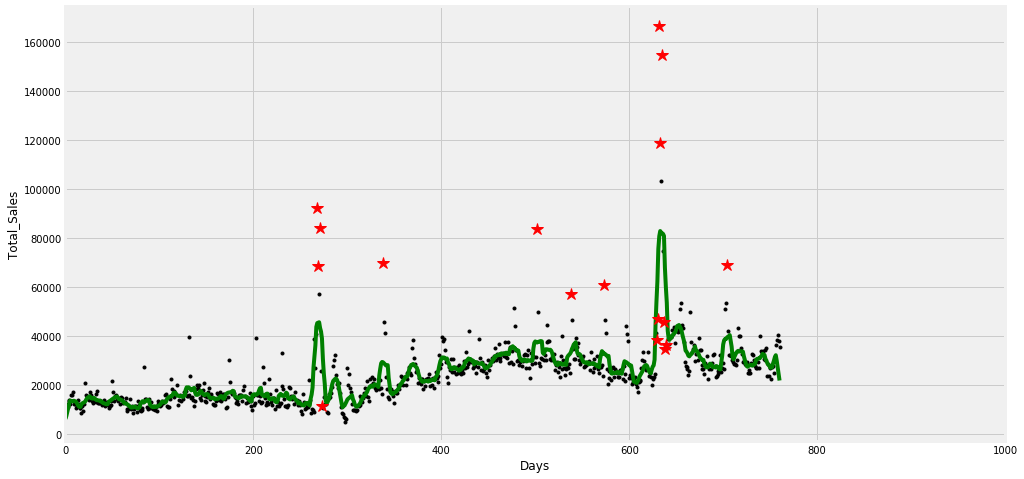

Information about the anomalies model:{'standard_deviation': 5989.24, 'anomalies_dict': OrderedDict([(203, 39229.86), (268, 92522.34), (271, 84129.75), (273, 11490.86), (337, 16334.81), (338, 69733.4), (502, 83795.24), (538, 57386.4), (573, 60778.65), (630, 38328.24), (631, 47235.39), (632, 166475.47), (634, 103505.4), (635, 154575.38), (637, 45675.31), (704, 69042.59)])}


In [16]:
x = data['days']
y = data['total_sales']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Days", sigma_value=3,
             text_ylabel="Total_Sales")
events = explain_anomalies(y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))